<a href="https://colab.research.google.com/github/amura/Deploying-deep-learning-model-to-web-and-mobile/blob/main/Deploying_deep_learning_model_on_web_and_mobile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import dependencies

In [ ]:
import pandas as pd
from io import BytesIO
import numpy as np
import os
import shutil
import pprint
import json
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import pathlib




Download training set




In [ ]:
data_source = "http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz"
tf.keras.utils.get_file("food-101", data_source, untar=True)


'/root/.keras/datasets/food-101'

In [ ]:
!ls /tmp/.keras/datasets/food-101/images


apple_pie	    eggs_benedict	     onion_rings
baby_back_ribs	    escargots		     oysters
baklava		    falafel		     pad_thai
beef_carpaccio	    filet_mignon	     paella
beef_tartare	    fish_and_chips	     pancakes
beet_salad	    foie_gras		     panna_cotta
beignets	    french_fries	     peking_duck
bibimbap	    french_onion_soup	     pho
bread_pudding	    french_toast	     pizza
breakfast_burrito   fried_calamari	     pork_chop
bruschetta	    fried_rice		     poutine
caesar_salad	    frozen_yogurt	     prime_rib
cannoli		    garlic_bread	     pulled_pork_sandwich
caprese_salad	    gnocchi		     ramen
carrot_cake	    greek_salad		     ravioli
ceviche		    grilled_cheese_sandwich  red_velvet_cake
cheesecake	    grilled_salmon	     risotto
cheese_plate	    guacamole		     samosa
chicken_curry	    gyoza		     sashimi
chicken_quesadilla  hamburger		     scallops
chicken_wings	    hot_and_sour_soup	     seaweed_salad
chocolate_cake	    hot_dog		     shrimp_and_grits
chocolate_mousse    huevo

In [ ]:
data_dir = pathlib.Path('/root/.keras/datasets/food-101')
print(data_dir)
!ls '/root/.keras/datasets/food-101'

/root/.keras/datasets/food-101
images	license_agreement.txt  meta  README.txt


Review image data

In [ ]:
image_count = len(list(data_dir.glob('**/*.jpg')))
print(image_count)

101000


# Explorer data


Read in the images and then split the data into training and validation using ImageDataGenerator. Only filtered down to five classes for performance reasons.


In [ ]:
batch_size = 32
img_height = 224
img_width = 224
# use image augmentation
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255., validation_split=0.2, 
                                                                rotation_range = 40, width_shift_range = 0.2, 
                                                                height_shift_range = 0.2, shear_range = 0.2, 
                                                                zoom_range = 0.2, horizontal_flip = True)

train_generator = train_datagen.flow_from_directory(
    classes=["baklava", "caesar_salad", "filet_mignon", "cup_cakes","garlic_bread"],
     directory=pathlib.Path(data_dir, "images"),  
     class_mode="categorical" ,
    subset="training",
    target_size=(img_height, img_width),
    batch_size=batch_size  
)

validation_generator = train_datagen.flow_from_directory(
     classes=["baklava", "caesar_salad", "filet_mignon", "cup_cakes","garlic_bread"],
     directory=pathlib.Path(data_dir, "images"),
     class_mode="categorical" ,
    subset="validation",
    target_size=(img_height, img_width),
    batch_size=batch_size  
)

Found 4000 images belonging to 5 classes.
Found 1000 images belonging to 5 classes.


In [ ]:
ALL_DATA_DIR = pathlib.Path(str(data_dir) + "/images")
ALL_CLASS_NAMES = sorted(np.array([item.name for item in ALL_DATA_DIR.glob('*')]))

print(ALL_CLASS_NAMES)

In [ ]:
# save class labels
with open(f"classes.json",'w') as f:
  json.dump(ALL_CLASS_NAMES,f)

# Training using Keras models
## VGG19
Create a VGG19 instance. Exclude the top dense classifier, as this will be replaced later on.

In [ ]:
from keras.applications import VGG19

conv_base = VGG19(weights='imagenet', include_top = False, input_shape=(img_width,img_height, 3))

In [ ]:
#summary
conv_base.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

Feature extraction by adding dense classifier

In [ ]:
from keras import models
from keras import layers

model = models.Sequential([
  conv_base,
  layers.GlobalAveragePooling2D(),
  layers.Dense(16, activation='relu'),
  layers.Dense(5, activation='softmax')                             
])

Freeze the base conv base layer and then compile the model

In [ ]:
from keras import optimizers
conv_base.trainable = False
print("number trainable weights", len(model.trainable_weights))
#compile
model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=1e-3), metrics=['acc'])

number trainable weights 4


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 16)                8208      
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 85        
Total params: 20,032,677
Trainable params: 8,293
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
from keras import callbacks
import time
# utility class for accumulating the training time
class TimeHistory(callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)
     

Fit the model

In [ ]:
num_epochs = 3
time_callback = TimeHistory()
history = model.fit( train_generator, epochs=num_epochs, batch_size=batch_size, validation_data=validation_generator, callbacks=[time_callback])
print("Timing summary", time_callback.times)

Epoch 1/3
125/125 [==============================] - 3164s 25s/step - loss: 1.4785 - acc: 0.3997 - val_loss: 1.3556 - val_acc: 0.5030
Epoch 2/3
125/125 [==============================] - 3162s 25s/step - loss: 1.2603 - acc: 0.5483 - val_loss: 1.1717 - val_acc: 0.6060
Epoch 3/3
125/125 [==============================] - 3177s 25s/step - loss: 1.0936 - acc: 0.6275 - val_loss: 1.0518 - val_acc: 0.6390
Timing summary [3186.3984344005585, 3182.984144449234, 3197.6677570343018]


keys {'loss': [1.4785491228103638, 1.2602944374084473, 1.0935695171356201], 'acc': [0.3997499942779541, 0.5482500195503235, 0.6274999976158142], 'val_loss': [1.3556373119354248, 1.1717218160629272, 1.0518183708190918], 'val_acc': [0.503000020980835, 0.6060000061988831, 0.6389999985694885]}


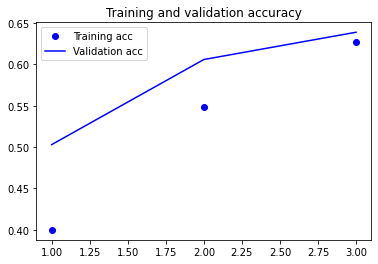

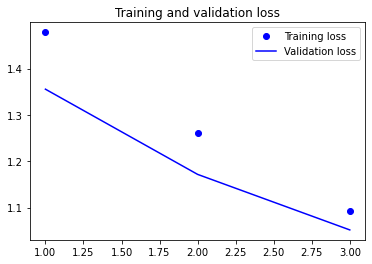

In [ ]:
acc = history.history['acc']
print("keys", history.history)
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


Saving the model to disc


In [ ]:
!mkdir -p saved_model
model.save("saved_model/model_vgg19.h5")

# Training summary
Model: "VGG19"

* Total params: 20,032,677
* Trainable params: 8,293
* Non-trainable params: 20,024,384
* Training time 9565s
* Accuracy 64%
* Model size: 76.5Mb




# ResNet50

In [ ]:
from keras.applications import ResNet50

resnet_base_model =ResNet50(input_shape=(img_width, img_height, 3), include_top=False, weights="imagenet")


94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
#freeze layers
resnet_base_model.trainable = False

In [ ]:
resnet_base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

Build and compile our model

In [ ]:
res_model = models.Sequential([
  resnet_base_model,
  layers.GlobalAveragePooling2D(),
  layers.Dense(16, activation='relu'),
  layers.Dense(5, activation='softmax')                             
])

In [ ]:
res_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                32784     
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 85        
Total params: 23,620,581
Trainable params: 32,869
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
res_model.compile(optimizer=optimizers.RMSprop(lr=1e-3), loss = 'categorical_crossentropy', metrics = ['acc'])


Fit the resnet model

In [ ]:
time_callback = TimeHistory()
res_history = res_model.fit(train_generator, epochs=num_epochs, batch_size=batch_size, validation_data=validation_generator, callbacks=[time_callback])
print("Timing summary", time_callback.times)

Epoch 1/3
125/125 [==============================] - 803s 6s/step - loss: 1.6074 - acc: 0.2362 - val_loss: 1.5861 - val_acc: 0.2330
Epoch 2/3
125/125 [==============================] - 798s 6s/step - loss: 1.5671 - acc: 0.2682 - val_loss: 1.5510 - val_acc: 0.2670
Epoch 3/3
125/125 [==============================] - 795s 6s/step - loss: 1.5370 - acc: 0.3010 - val_loss: 1.5166 - val_acc: 0.3290
Timing summary [812.4365546703339, 803.8132395744324, 800.3687536716461]


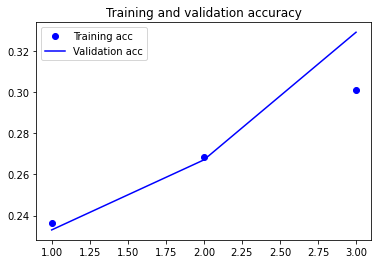

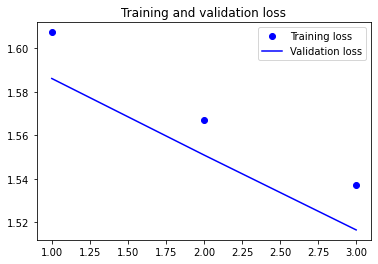

In [ ]:
acc = res_history.history['acc']
val_acc =res_history.history['val_acc']
loss = res_history.history['loss']
val_loss = res_history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
res_model.save("saved_model/model_res.h5")

# Training summary
Model: "ResNet50"

* Total params: 23,620,581
* Trainable params: 32,869
* Non-trainable params: 23,587,712
* Training time 2,396s
* Accuracy 32%
* Model size: 94.3Mb




# MobileNetV2

In [ ]:
from keras.applications import MobileNetV2

mobile_base_model =MobileNetV2(input_shape=(img_width, img_height, 3), include_top=False, weights="imagenet")

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
#freeze layers
mobile_base_model.trainable = False

In [ ]:
mobile_base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

Build and compile our model

In [ ]:
mobile_model = models.Sequential([
  mobile_base_model,
  layers.GlobalAveragePooling2D(),
  layers.Dense(16, activation='relu'),
  layers.Dense(5, activation='softmax')                             
])

In [ ]:
# compile
mobile_model.compile(optimizer=optimizers.RMSprop(lr=1e-3), loss = 'categorical_crossentropy', metrics = ['acc'])

In [ ]:
mobile_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1280)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 16)                20496     
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 85        
Total params: 2,278,565
Trainable params: 20,581
Non-trainable params: 2,257,984
_________________________________________________________________


Fit

In [ ]:
time_callback = TimeHistory()
mobile_history = mobile_model.fit(train_generator, epochs=num_epochs, batch_size=batch_size, validation_data=validation_generator, callbacks=[time_callback])
print("Timing summary", time_callback.times)

Epoch 1/3
125/125 [==============================] - 232s 2s/step - loss: 0.7555 - acc: 0.7090 - val_loss: 0.5120 - val_acc: 0.8260
Epoch 2/3
125/125 [==============================] - 230s 2s/step - loss: 0.4175 - acc: 0.8528 - val_loss: 0.3935 - val_acc: 0.8690
Epoch 3/3
125/125 [==============================] - 229s 2s/step - loss: 0.3724 - acc: 0.8660 - val_loss: 0.3861 - val_acc: 0.8590
Timing summary [236.14454579353333, 232.19764637947083, 230.9645266532898]


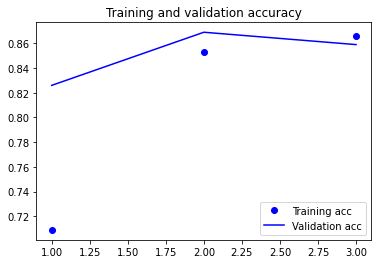

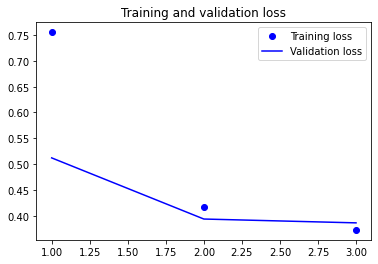

In [ ]:
acc = mobile_history.history['acc']
val_acc =mobile_history.history['val_acc']
loss = mobile_history.history['loss']
val_loss = mobile_history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
model.save("saved_model/model_mobile.h5")

In [ ]:
!pip install tensorflowjs==3.0.0

In [ ]:
!tensorflowjs_converter ./saved_model/model_res.h5 model_tfjs  --input_format keras --output_format tfjs_graph_model --weight_shard_size_bytes 50000000 --quantize_float16

# Training summary
Model: "MobileNet"

* Total params: 2,278,565
* Trainable params: 20,581
* Non-trainable params: 2,257,984
* Training time 698s
* Accuracy 87%
* Model size: 76.5Mb




# Summary

<table>
  <tr>
    <th>Model</th>
    <th>Trainable parameters</th>
    <th>Non trainable parameters</th>
    <th>Time (hh:mm:ss)</th>
    <th>Accuracy (%)</th>
    <th>Epochs</th>
    <th>Model size</th>
  </tr>
  <tr>
   <td>VGG19</td>
   <td>8,293</td>
   <td>20,024,384</td>
   <td>2:39:25</td>
   <td> 64</td>
   <td> 3</td>
   <td> 76.5</td>    
  </tr>
   <tr>
   <td>ResNet50</td>
   <td>32,869</td>
   <td>23,587,712</td>
   <td>0:39:55</td>
   <td> 32</td>
   <td> 3</td>
   <td> 94.3</td>    
  </tr>
    <tr>
   <td>MobileNetV2</td>
   <td>32,869</td>
   <td>23,587,712</td>
   <td>0:11:37</td>
   <td> 87</td>
   <td> 3</td>
   <td> 76.5</td>    
  </tr>
</table>